# Predicting Diabetes Patient re-admission Rate

In [2]:
#imports
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import re
import seaborn as sb
from sklearn.model_selection import train_test_split

**We aim to see if using patient data we can predict readmission rates. Our goal in this project is classification of patients into those that will be readmitted and those that will not be**

## Set Up
### Import data

In [5]:
df = pd.read_csv("diabetic_data.csv")

In [6]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
encounter_id,2278392,149190,64410,500364,16680,35754,55842,63768,12522,15738
patient_nbr,8222157,55629189,86047875,82442376,42519267,82637451,84259809,114882984,48330783,63555939
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male,Male,Male,Male,Female,Female
age,[0-10),[10-20),[20-30),[30-40),[40-50),[50-60),[60-70),[70-80),[80-90),[90-100)
weight,?,?,?,?,?,?,?,?,?,?
admission_type_id,6,1,1,1,1,2,3,1,2,3
discharge_disposition_id,25,1,1,1,1,1,1,1,1,3
admission_source_id,1,7,7,7,7,2,2,7,4,4
time_in_hospital,1,3,2,2,1,3,4,5,13,12


## Data exploration and transformation

In [8]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride         

**We currently have 50 features. Our Data is structured and split between numerical Data and 
categorical data such as race and gender**

#### Data transformation of the "readmitted" attribute
We want to predict whether a patient is more likely to be admitted. We do not care about how many days they were readmited for. The readmited column of the data currently shows if they were not readmitted (keyword: "NO"), if they were readmited for less that 30 days (keyword: "<30") or if they are readmitted for more than 30 days (keyword: ">30").

We will be making a new column called readmitted_binary so it contains a binary numerical value:
- 1 if the patient was readmitted
- 0 If they were not

In [11]:
df['readmitted_binary'] = df['readmitted'].apply(lambda x: 1 if x == ">30" or x == "<30" else 0)

In [12]:
# We make sure we only have 1 or 0 in readmitted column
unique_vals = df['readmitted_binary'].unique()

print("Unique values in 'readmitted_binary' column:")
print(unique_vals)

Unique values in 'readmitted_binary' column:
[0 1]


Our data appears to be very skewed in one direction. We will have to address this later before training our model

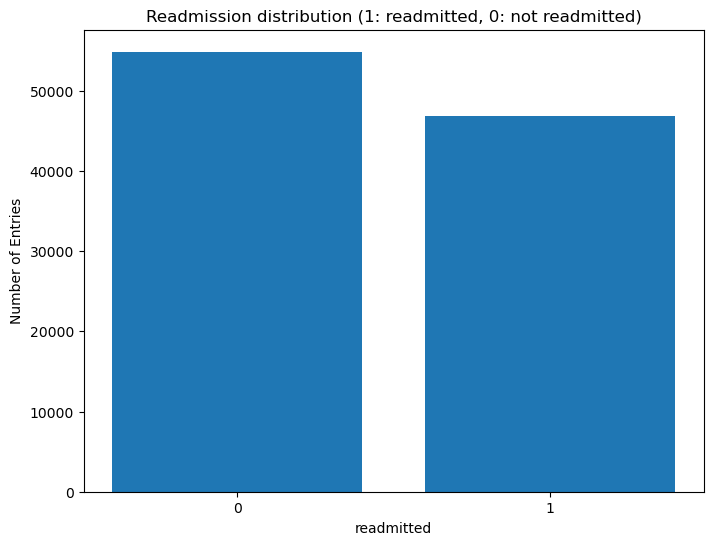

In [14]:
# Step 1: Count the occurrences of each unique value in the 'Category' column
category_counts = df['readmitted_binary'].value_counts()

# Step 2: Plot the results using seaborn barplot
plt.figure(figsize=(8, 6))
plt.bar(category_counts.index, category_counts.values)

# Step 3: Only show ticks for categories with a count > 0
plt.xticks(ticks=range(len(category_counts)), labels=category_counts.index)

# Add labels and title
plt.xlabel('readmitted')
plt.ylabel('Number of Entries')
plt.title('Readmission distribution (1: readmitted, 0: not readmitted)')

# Show the plot
plt.show()

### Explore Demographics

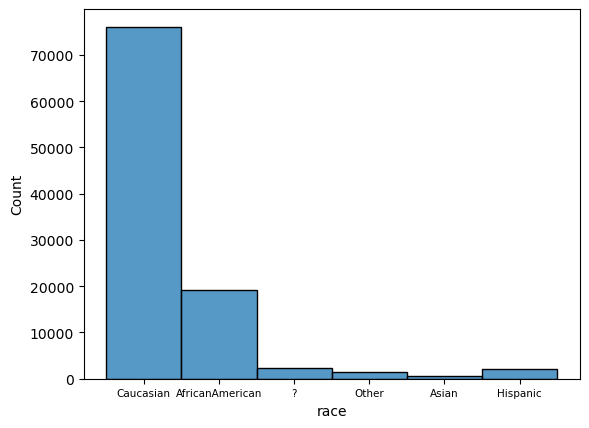

In [16]:
sb.histplot(df['race'])
plt.xticks(fontsize=7.5)
plt.show()

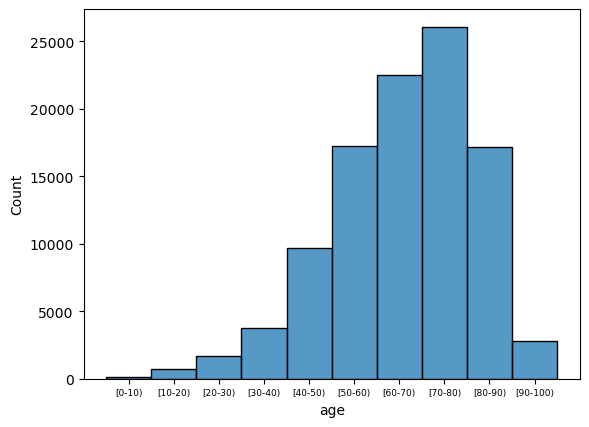

In [17]:
sb.histplot(df['age'])
plt.xticks(fontsize=6.5)
plt.show()

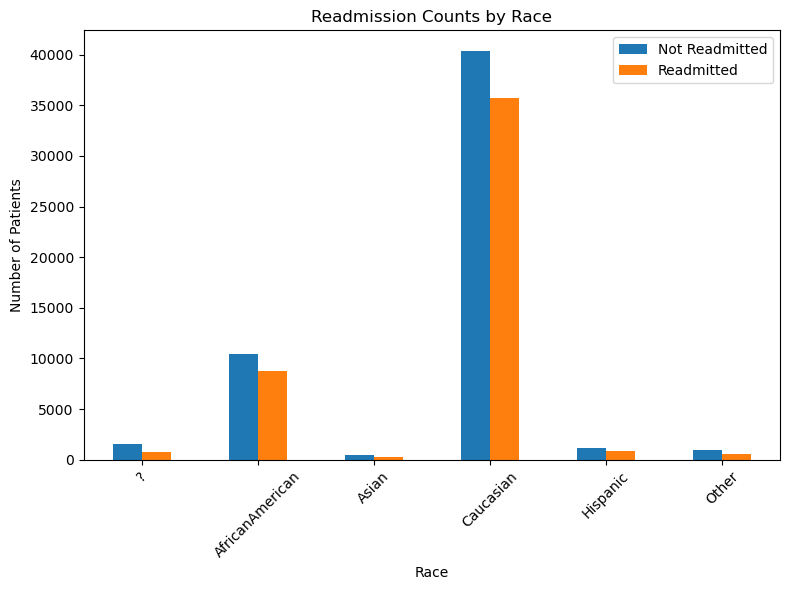

In [18]:
race_readmitted_counts = df.groupby(['race', 'readmitted_binary']).size().unstack(fill_value=0)

race_readmitted_counts.plot(kind='bar', stacked=False, figsize=(8, 6))

plt.xlabel('Race')
plt.ylabel('Number of Patients')
plt.title('Readmission Counts by Race')

plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend(['Not Readmitted', 'Readmitted'])
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

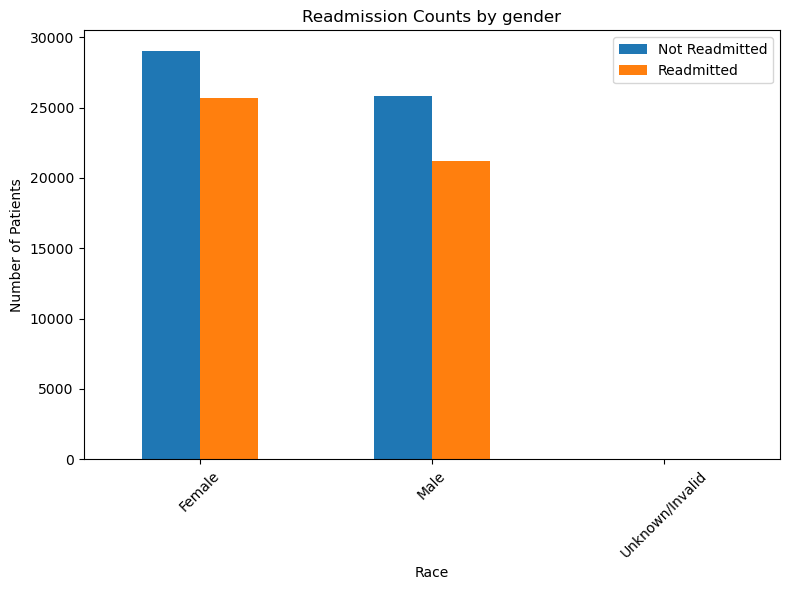

In [19]:
race_readmitted_counts = df.groupby(['gender', 'readmitted_binary']).size().unstack(fill_value=0)

race_readmitted_counts.plot(kind='bar', stacked=False, figsize=(8, 6))

plt.xlabel('Race')
plt.ylabel('Number of Patients')
plt.title('Readmission Counts by gender')

plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend(['Not Readmitted', 'Readmitted'])
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

Time spent in hospital vs readmission

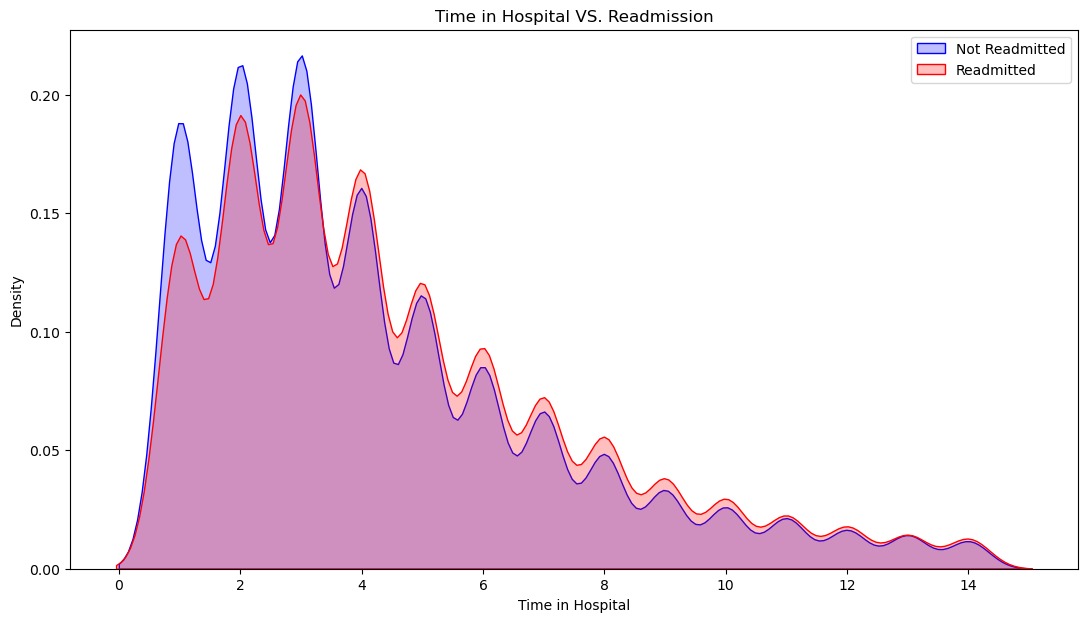

In [21]:
fig = plt.figure(figsize=(13,7),)
ax=sb.kdeplot(df.loc[(df['readmitted_binary'] == 0),'time_in_hospital'] , color='b',fill=True,label='Not Readmitted')
ax=sb.kdeplot(df.loc[(df['readmitted_binary'] == 1),'time_in_hospital'] , color='r',fill=True, label='Readmitted')
ax.set(xlabel='Time in Hospital', ylabel='Density')
plt.title('Time in Hospital VS. Readmission')
plt.legend()

There is not a very clear distinction between likelyhood to be readmitted and not readmitted based on time spent in the hospital 

## Data cleaning and Feature generation

Drop all unnecessary columns

In [25]:
# Drop columns with too many missing values
df = df.drop(['weight','payer_code','medical_specialty'], axis = 1)
# Remove data with all of the same values
df = df.drop(['citoglipton', 'examide'], axis = 1)

Clean Data of unknown values

In [27]:
#Checking for missing values in the data
for col in df.columns:
    if df[col].dtype == object:
         print(col,df[col][df[col] == '?'].count())
            
print('gender', df['gender'][df['gender'] == 'Unknown/Invalid'].count()) 

race 2273
gender 0
age 0
diag_1 21
diag_2 358
diag_3 1423
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0
gender 3


In [28]:
drop_Idx = set(df[(df['diag_1'] == '?') & (df['diag_2'] == '?') & (df['diag_3'] == '?')].index)

drop_Idx = drop_Idx.union(set(df['diag_1'][df['diag_1'] == '?'].index))
drop_Idx = drop_Idx.union(set(df['diag_2'][df['diag_2'] == '?'].index))
drop_Idx = drop_Idx.union(set(df['diag_3'][df['diag_3'] == '?'].index))
drop_Idx = drop_Idx.union(set(df['race'][df['race'] == '?'].index))
drop_Idx = drop_Idx.union(set(df[df['discharge_disposition_id'] == 11].index))
drop_Idx = drop_Idx.union(set(df['gender'][df['gender'] == 'Unknown/Invalid'].index))
new_Idx = list(set(df.index) - set(drop_Idx))
df = df.iloc[new_Idx]

In [29]:
#Checking for missing values in the data
for col in df.columns:
    if df[col].dtype == object:
         print(col,df[col][df[col] == '?'].count())
            
print('gender', df['gender'][df['gender'] == 'Unknown/Invalid'].count()) 

race 0
gender 0
age 0
diag_1 0
diag_2 0
diag_3 0
max_glu_serum 0
A1Cresult 0
metformin 0
repaglinide 0
nateglinide 0
chlorpropamide 0
glimepiride 0
acetohexamide 0
glipizide 0
glyburide 0
tolbutamide 0
pioglitazone 0
rosiglitazone 0
acarbose 0
miglitol 0
troglitazone 0
tolazamide 0
insulin 0
glyburide-metformin 0
glipizide-metformin 0
glimepiride-pioglitazone 0
metformin-rosiglitazone 0
metformin-pioglitazone 0
change 0
diabetesMed 0
readmitted 0
gender 0


Change string values in data set to integers

In [31]:
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']

pd.set_option('future.no_silent_downcasting', True)
df['change'] = df['change'].replace('Ch', 1)
df['change'] = df['change'].replace('No', 0)
df['gender'] = df['gender'].replace('Male', 1)
df['gender'] = df['gender'].replace('Female', 0)
df['diabetesMed'] = df['diabetesMed'].replace('Yes', 1)
df['diabetesMed'] = df['diabetesMed'].replace('No', 0)

# keys is the same as before
for col in keys:
    df[col] = df[col].replace('No', 0)
    df[col] = df[col].replace('Steady', 1)
    df[col] = df[col].replace('Up', 1)
    df[col] = df[col].replace('Down', 1)
    
df['A1Cresult'] = df['A1Cresult'].replace('>7', 1)
df['A1Cresult'] = df['A1Cresult'].replace('>8', 1)
df['A1Cresult'] = df['A1Cresult'].replace('Norm', 0)
df['A1Cresult'] = df['A1Cresult'].replace('None', -99)
df['max_glu_serum'] = df['max_glu_serum'].replace('>200', 1)
df['max_glu_serum'] = df['max_glu_serum'].replace('>300', 1)
df['max_glu_serum'] = df['max_glu_serum'].replace('Norm', 0)
df['max_glu_serum'] = df['max_glu_serum'].replace('None', -99)

Changing age category to mid point values and scaling them down

In [33]:
# code age intervals [0-10) - [90-100) from 1-10
for i in range(0,10):
    df['age'] = df['age'].replace('['+str(10*i)+'-'+str(10*(i+1))+')', i+1)
df['age'].value_counts()


age
8     24815
7     21521
6     16546
9     16223
5      9208
4      3538
10     2594
3      1471
2       466
1        64
Name: count, dtype: int64

Change race into integer value

In [35]:
unique_races = df['race'].unique()

# Print the unique values
print(f"Unique races {unique_races}")
race_col = 'race'
df[race_col] = df[race_col].replace('Caucasian', 1)
df[race_col] = df[race_col].replace('Other', 2)
df[race_col] = df[race_col].replace('AfricanAmerican', 3)
df[race_col] = df[race_col].replace('Hispanic', 4)
df[race_col] = df[race_col].replace('Asian', 5)

col_to_change_to_int = 'race'

df[col_to_change_to_int] = pd.to_numeric(df[col_to_change_to_int], errors='coerce')
has_nan = df[col_to_change_to_int].isna().any()
print(has_nan)
df[col_to_change_to_int] = df[col_to_change_to_int].fillna(0).astype(int)  # Replace NaN with 0 and convert to int

Unique races ['Caucasian' 'AfricanAmerican' 'Other' 'Asian' 'Hispanic']
False


In [36]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                         int32
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide           

Change test values to integers

In [38]:
keys = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'insulin', 'glyburide-metformin', 'tolazamide', 'metformin-pioglitazone','metformin-rosiglitazone', 'glimepiride-pioglitazone', 'glipizide-metformin', 'troglitazone', 'tolbutamide', 'acetohexamide']
for col in keys:
    df[col] = df[col].apply(lambda x: 0 if (x == 'No' or x == 'Steady') else 1)

In [39]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                         int32
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                    int64
repaglinide                  int64
nateglinide                  int64
chlorpropamide               int64
glimepiride                  int64
acetohexamide                int64
glipizide                    int64
glyburide           

Change all features to be used for our model to int

In [41]:
cols_to_change_to_int = ['age', 'gender', 'A1Cresult', 'diabetesMed', 'change', 'max_glu_serum' ]
for col_to_change_to_int in cols_to_change_to_int:    
    df[col_to_change_to_int] = pd.to_numeric(df[col_to_change_to_int], errors='coerce')
    has_nan = df[col_to_change_to_int].isna().any()
    print(has_nan)
    df[col_to_change_to_int] = df[col_to_change_to_int].fillna(0).astype(int)  # Replace NaN with 0 and convert to int

False
False
True
False
False
True


In [42]:
df.dtypes

encounter_id                 int64
patient_nbr                  int64
race                         int32
gender                       int32
age                          int32
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum                int32
A1Cresult                    int32
metformin                    int64
repaglinide                  int64
nateglinide                  int64
chlorpropamide               int64
glimepiride                  int64
acetohexamide                int64
glipizide                    int64
glyburide           

## Data Modelling

In [44]:
# Get all column names
column_names = df.columns
# Convert to list if you want it as a regular list
feature_set_int = column_names.tolist()
print(feature_set_int)

['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted', 'readmitted_binary']


I dropped the id numbers and also the diagnoses data. The diagnoses data was dropped because it was notin a format the model would understand


In [46]:
columns_to_drop = ['readmitted_binary','readmitted','encounter_id', 'patient_nbr','weight','payer_code','medical_specialty','citoglipton', 'examide', "diag_1", "diag_2", "diag_3",'level1_diag1', 'readmitted']
feature_set_int = [item for item in feature_set_int if item not in columns_to_drop]
X = df[feature_set_int]
Y = df['readmitted_binary']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=0)

### Decision tree

In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

dtree = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=28, min_samples_split=10)

In [50]:
y_prd = dtree.predict(X_test)
y_prd_list = y_prd.tolist()
y_test_list = y_test.tolist()
pd.crosstab(pd.Series(y_test_list, name = 'Actual'), pd.Series(y_prd_list, name = 'Predict'), margins = True)


Predict,0,1,All
Actual,,,
0,6012,4054,10066
1,4558,4666,9224
All,10570,8720,19290


In [52]:
print("Accuracy is {0:.4f}".format(accuracy_score(y_test, y_prd)))
print("Precision is {0:.4f}".format(precision_score(y_test, y_prd)))
print("Recall is {0:.4f}".format(recall_score(y_test, y_prd)))
print("F1 is {0:.4f}".format(f1_score(y_test, y_prd)))

accuracy_rm = accuracy_score(y_test, y_prd)
precision_rm = precision_score(y_test,y_prd)
recall_rm = recall_score(y_test, y_prd)
f1_rm = f1_score(y_test, y_prd)

Accuracy is 0.5536
Precision is 0.5351
Recall is 0.5059
F1 is 0.5201


### Random Forest

In [54]:
from sklearn.ensemble import RandomForestClassifier

In [56]:
rm = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "gini", min_samples_split=10)
rm.fit(X_train, y_train)

RandomForestClassifier(max_depth=25, min_samples_split=10, n_estimators=10)

In [58]:
y_prd = rm.predict(X_test)
y_prd_list = y_prd.tolist()
y_test_list = y_test.tolist()
pd.crosstab(pd.Series(y_test_list, name = 'Actual'), pd.Series(y_prd_list, name = 'Predict'), margins = True)


Predict,0,1,All
Actual,,,
0,6776,3290,10066
1,4299,4925,9224
All,11075,8215,19290


In [60]:
print("Accuracy is {0:.4f}".format(accuracy_score(y_test, y_prd)))
print("Precision is {0:.4f}".format(precision_score(y_test, y_prd)))
print("Recall is {0:.4f}".format(recall_score(y_test, y_prd)))
print("F1 is {0:.4f}".format(f1_score(y_test, y_prd)))

accuracy_rm = accuracy_score(y_test, y_prd)
precision_rm = precision_score(y_test,y_prd)
recall_rm = recall_score(y_test, y_prd)
f1_rm = f1_score(y_test, y_prd)

Accuracy is 0.6066
Precision is 0.5995
Recall is 0.5339
F1 is 0.5648
